<span style="color:black">

### **Example 5.5**

This example serves to introduce the concept of **signal space**, which is used extensively to understand and interpret communications and radar-type detection problems from a geometrical point of view. 

To start the understanding, consider two potential noise-free signals:

$$
u_0(t) = 1, \quad 0 \leq t \leq 1, \quad \text{hypothesis } H_0
$$

$$
u_1(t) = e^{j \beta}, \quad 0 \leq t \leq 1, \quad \text{hypothesis } H_1 
$$

Thus, the two signals have equal energy:

$$
\mathcal{E}_0 = \mathcal{E}_1 = \frac{1}{2} \int_0^T |u_0(t)|^2 dt = \frac{1}{2} \int_0^T |u_1(t)|^2 dt = \frac{T}{2}  
$$

and the correlation between them is:

$$
\rho = \frac{1}{T} \int_0^T e^{-j \beta} \, dt = e^{-j \beta} 
$$

The error rate using these signals embedded in additive white Gaussian noise is

$$
P(E) = \frac{1}{2} \, \text{erfc} \left( \sqrt{\frac{\mathcal{E} (1 - \cos \beta)}{2 N_0}} \right)  
$$

We can examine the performance with different signal-space representation of the two signals under different $ \beta $.

### Simulation using Matched Filter

Beta = 0.7853981633974483 radians
Theoretical Error Rate: 0.2942
Empirical Error Rate: 0.2939

Beta = 3.141592653589793 radians
Theoretical Error Rate: 0.0786
Empirical Error Rate: 0.0784



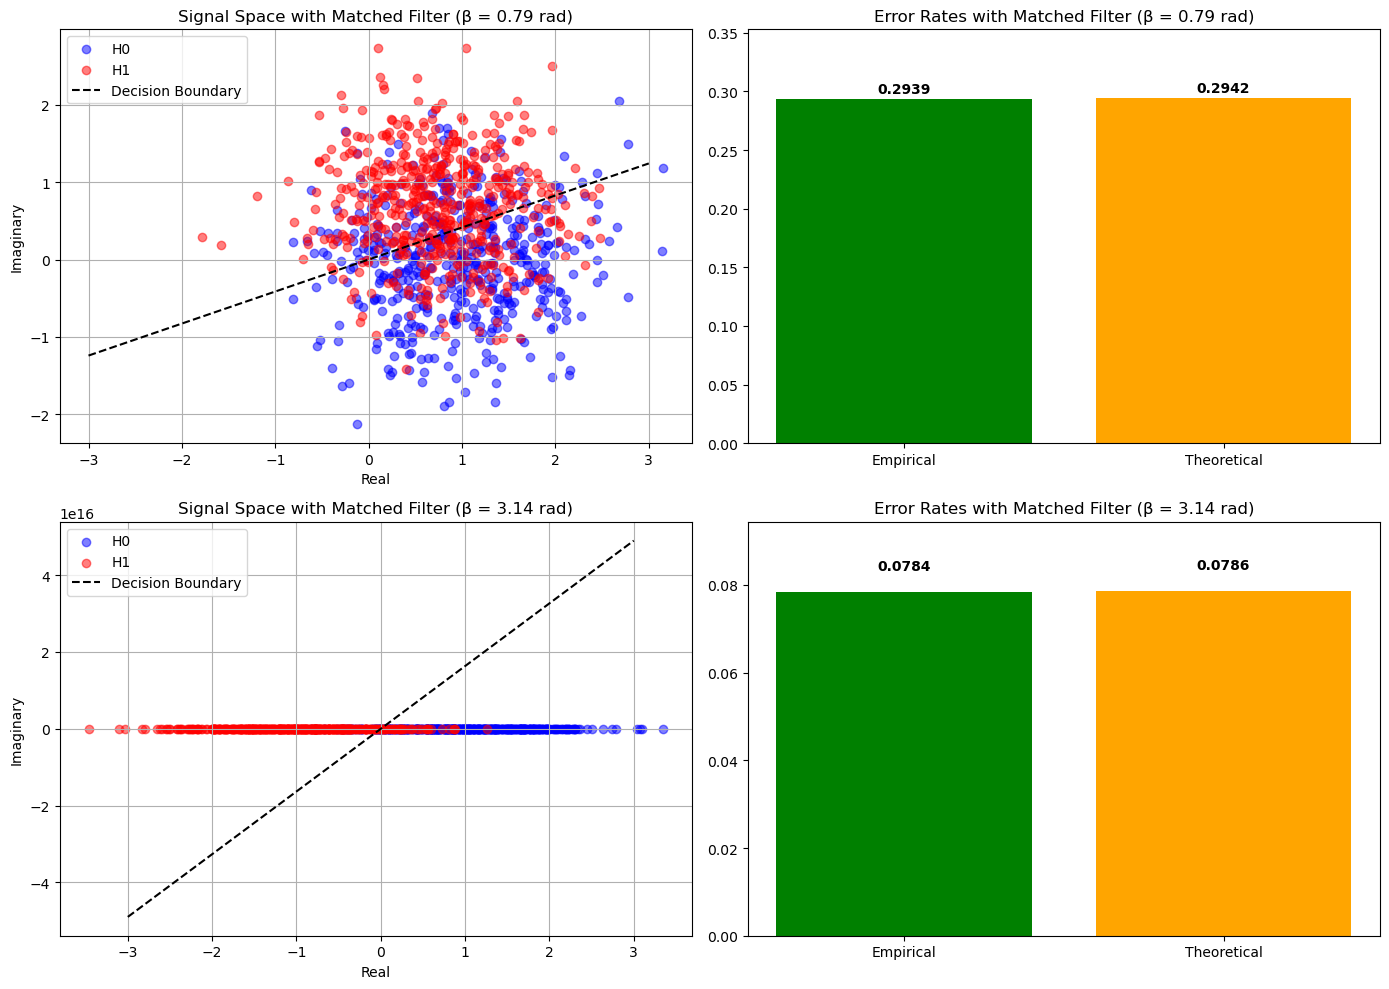

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Simulation Parameters
T = 1  # Duration
E = 0.5  # Energy
N0 = 1  # Noise power
num_trials = 100000  # Number of trials
beta_values = [np.pi / 4, np.pi ]  # Beta values to simulate

# Function to generate noise
def generate_noise(num_samples):
    # AWGN: real and imaginary parts are Gaussian with variance N0/2
    noise_real = np.random.normal(0, np.sqrt(N0 / 2), num_samples)
    noise_imag = np.random.normal(0, np.sqrt(N0 / 2), num_samples)
    return noise_real + 1j * noise_imag

# Function to compute theoretical error rate
def theoretical_error(E, beta, N0):
    # Must be 2E for COMPLEX BASEBAND SIGNAL
    argument = np.sqrt((2*E * (1 - np.cos(beta))) / (2 * N0))
    return 0.5 * erfc(argument)

# Function to perform simulation using matched filter for a given beta
def simulate_matched_filter(beta):
    # Define signals
    u0 = 1  # Hypothesis H0
    u1 = np.exp(1j * beta)  # Hypothesis H1

    # Generate random hypotheses
    # Assign H0 and H1 with equal probability
    hypotheses = np.random.choice(['H0', 'H1'], size=num_trials)
    transmitted_signals = np.where(hypotheses == 'H0', u0, u1)

    # Add noise
    noise = generate_noise(num_trials)
    received_signals = transmitted_signals + noise

    # Apply matched filters
    # Matched filter for H0: h0(t) = u0*(t) = 1
    # Matched filter for H1: h1(t) = u1*(t) = e^{-j*beta}
    y0 = received_signals * 1  # Since h0(t) = 1
    y1 = received_signals * np.exp(-1j * beta)  # h1(t) = e^{-j*beta}

    # Integrate over time T (since u0 and u1 are constant over [0, T])
    # In discrete simulation, integration is equivalent to multiplication by T=1
    # So, y0 and y1 are already the integrals

    # Take real parts
    y0_real = np.real(y0)
    y1_real = np.real(y1)

    # Decision rule: Decide H0 if Re(y0) > Re(y1), else H1
    decisions = np.where(y0_real > y1_real, 'H0', 'H1')

    # Compute error rate
    errors = (decisions != hypotheses)
    empirical_error = np.mean(errors)

    # Compute theoretical error rate
    theo_error = theoretical_error(E, beta, N0)

    # Prepare data for signal space plot (only a subset for visualization)
    subset = 1000  # Number of points to plot
    received_subset = received_signals[:subset]
    hypotheses_subset = hypotheses[:subset]
    decisions_subset = decisions[:subset]

    return empirical_error, theo_error, received_subset, hypotheses_subset, decisions_subset

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, beta in enumerate(beta_values):
    empirical_error, theo_error, received_subset, hypotheses_subset, decisions_subset = simulate_matched_filter(beta)
    
    print(f"Beta = {beta} radians")
    print(f"Theoretical Error Rate: {theo_error:.4f}")
    print(f"Empirical Error Rate: {empirical_error:.4f}\n")
    
    # Plot signal space
    ax1 = axes[idx, 0]
    ax2 = axes[idx, 1]
    
    # Plot received signals with different colors for H0 and H1
    H0_indices = hypotheses_subset == 'H0'
    H1_indices = hypotheses_subset == 'H1'
    ax1.scatter(received_subset[H0_indices].real, received_subset[H0_indices].imag, 
                color='blue', alpha=0.5, label='H0')
    ax1.scatter(received_subset[H1_indices].real, received_subset[H1_indices].imag, 
                color='red', alpha=0.5, label='H1')
    
    # Plot decision boundary
    # The decision boundary is defined by Re(y0) = Re(y1)
    # Which implies Re(r) = Re(r e^{-j beta})
    # To visualize, we can plot the line where Re(r) - Re(r e^{-j beta}) = 0
    # Simplify: Re(r) - Re(r e^{-j beta}) = 0
    # Let r = x + jy
    # Re(r e^{-j beta}) = x cos(beta) + y sin(beta)
    # So, x - (x cos(beta) + y sin(beta)) = 0 => x (1 - cos(beta)) - y sin(beta) = 0
    # This is a straight line: y = (1 - cos(beta)) / sin(beta) * x
    if beta != 0:
        slope = (1 - np.cos(beta)) / np.sin(beta)
        x_vals = np.linspace(-3, 3, 1000)
        y_vals = slope * x_vals
        ax1.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
    
    ax1.set_title(f'Signal Space with Matched Filter (β = {beta:.2f} rad)')
    ax1.set_xlabel('Real')
    ax1.set_ylabel('Imaginary')
    ax1.legend()
    ax1.grid(True)
    
    # Plot theoretical vs empirical error
    ax2.bar(['Empirical', 'Theoretical'], [empirical_error, theo_error], 
            color=['green', 'orange'])
    ax2.set_ylim(0, max(empirical_error, theo_error)*1.2)
    ax2.set_title(f'Error Rates with Matched Filter (β = {beta:.2f} rad)')
    for i, v in enumerate([empirical_error, theo_error]):
        ax2.text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Simulation using Euclidean Distance

Beta = 1.5707963267948966 radians
Theoretical Error Rate: 0.1587
Empirical Error Rate: 0.1581

Beta = 3.141592653589793 radians
Theoretical Error Rate: 0.0786
Empirical Error Rate: 0.0781



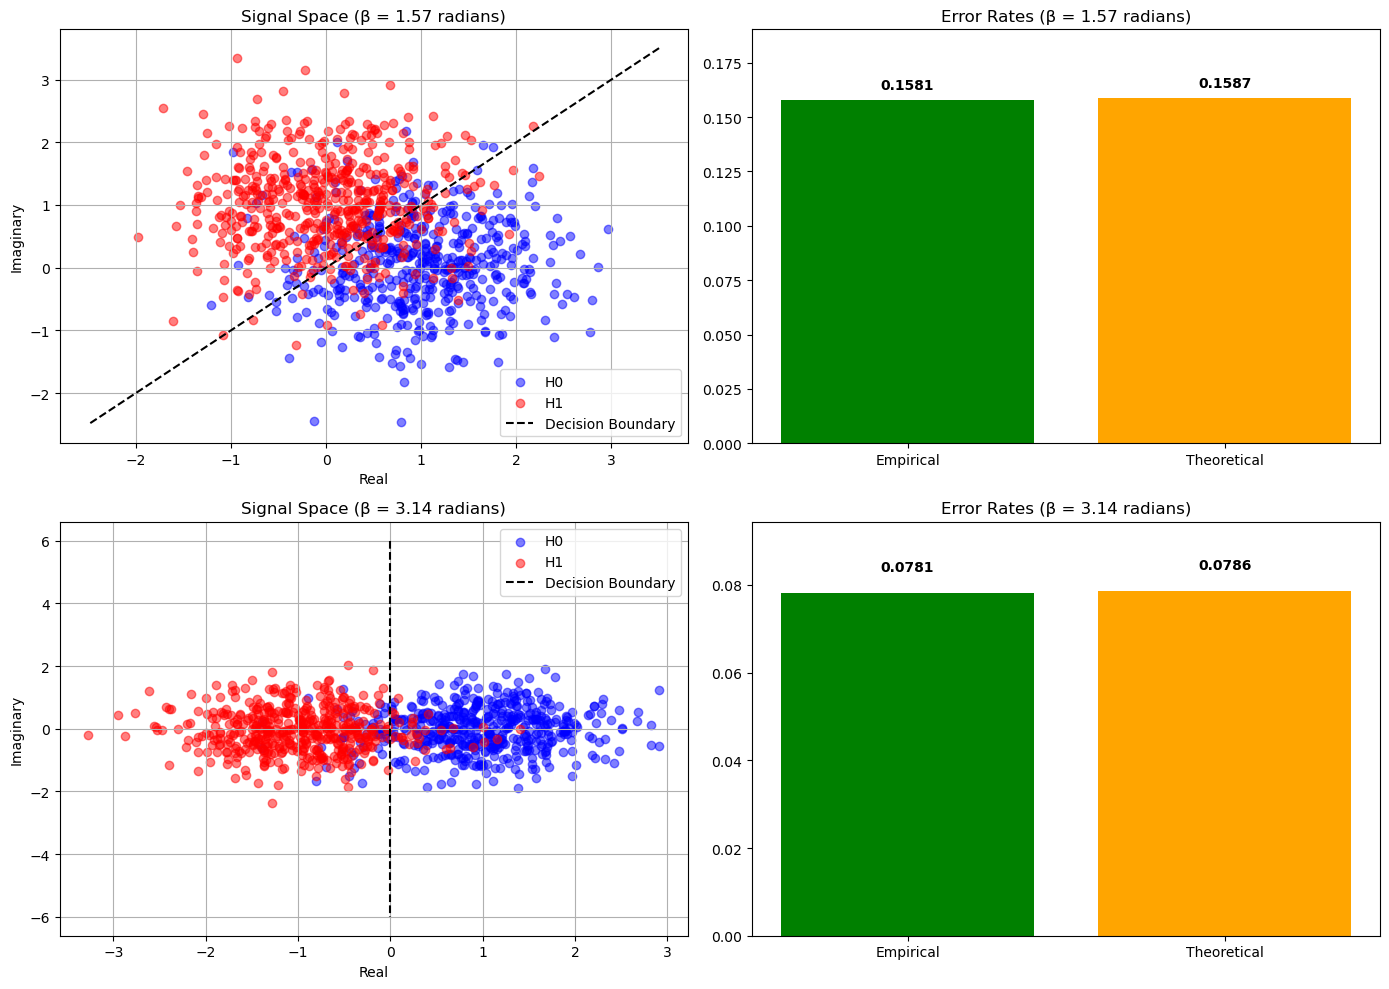

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Simulation Parameters
T = 1  # Duration
E = 0.5  # Energy
N0 = 1  # Noise power
num_trials = 1000000  # Number of trials
beta_values = [np.pi / 2, np.pi]  # Beta values to simulate

# Function to generate noise
def generate_noise(num_samples):
    # AWGN: real and imaginary parts are Gaussian with variance N0/2
    noise_real = np.random.normal(0, np.sqrt(N0 / 2), num_samples)
    noise_imag = np.random.normal(0, np.sqrt(N0 / 2), num_samples)
    return noise_real + 1j * noise_imag

# Function to compute theoretical error rate
def theoretical_error(E, beta, N0):
    # Must be 2E for COMPLEX BASEBAND SIGNAL
    argument = np.sqrt((2*E * (1 - np.cos(beta))) / (2 * N0))
    return 0.5 * erfc(argument)

# Function to perform simulation for a given beta
def simulate(beta):
    # Define signals
    u0 = 1  # Hypothesis H0
    u1 = np.exp(1j * beta)  # Hypothesis H1

    # Generate random hypotheses
    hypotheses = np.random.choice(['H0', 'H1'], size=num_trials)
    transmitted_signals = np.where(hypotheses == 'H0', u0, u1)

    # Add noise
    noise = generate_noise(num_trials)
    received_signals = transmitted_signals + noise

    # Decision rule: Choose H0 if closer to u0, else H1
    # Compute Euclidean distance in signal space
    distance_H0 = np.abs(received_signals - u0)**2
    distance_H1 = np.abs(received_signals - u1)**2
    decisions = np.where(distance_H0 < distance_H1, 'H0', 'H1')

    # Compute error rate
    errors = (decisions != hypotheses)
    empirical_error = np.mean(errors)

    # Compute theoretical error rate
    theo_error = theoretical_error(E, beta, N0)

    # Prepare data for signal space plot (only a subset for visualization)
    subset = 1000  # Number of points to plot
    received_subset = received_signals[:subset]
    hypotheses_subset = hypotheses[:subset]
    decisions_subset = decisions[:subset]

    return empirical_error, theo_error, received_subset, hypotheses_subset, decisions_subset

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, beta in enumerate(beta_values):
    empirical_error, theo_error, received_subset, hypotheses_subset, decisions_subset = simulate(beta)
    
    print(f"Beta = {beta} radians")
    print(f"Theoretical Error Rate: {theo_error:.4f}")
    print(f"Empirical Error Rate: {empirical_error:.4f}\n")
    
    # Plot signal space
    ax1 = axes[idx, 0]
    ax2 = axes[idx, 1]
    
    # Plot received signals with different colors for H0 and H1
    H0_indices = hypotheses_subset == 'H0'
    H1_indices = hypotheses_subset == 'H1'
    ax1.scatter(received_subset[H0_indices].real, received_subset[H0_indices].imag, 
                color='blue', alpha=0.5, label='H0')
    ax1.scatter(received_subset[H1_indices].real, received_subset[H1_indices].imag, 
                color='red', alpha=0.5, label='H1')
    
    # Plot decision boundary
    # The decision boundary is the perpendicular bisector between u0 and u1
    # Compute midpoint
    midpoint = (1 + np.exp(1j * beta)) / 2
    # Compute the normal vector
    normal = 1j * (np.exp(1j * beta) - 1)
    # Generate a line for decision boundary
    t = np.linspace(-3, 3, 1000)
    boundary = midpoint + normal * t
    ax1.plot(boundary.real, boundary.imag, 'k--', label='Decision Boundary')
    
    ax1.set_title(f'Signal Space (β = {beta:.2f} radians)')
    ax1.set_xlabel('Real')
    ax1.set_ylabel('Imaginary')
    ax1.legend()
    ax1.grid(True)
    
    # Plot theoretical vs empirical error
    ax2.bar(['Empirical', 'Theoretical'], [empirical_error, theo_error], 
            color=['green', 'orange'])
    ax2.set_ylim(0, max(empirical_error, theo_error)*1.2)
    ax2.set_title(f'Error Rates (β = {beta:.2f} radians)')
    for i, v in enumerate([empirical_error, theo_error]):
        ax2.text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')
    
plt.tight_layout()
plt.show()
